In [1]:
import cftime
import numpy as np
import xarray as xr
import climpred
import proplot as plot
import glob
from tqdm import tqdm
import dask.array as da
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FixedLocator
import xskillscore as xs
import math
import warnings
warnings.filterwarnings("ignore")

from dask.distributed import Client
import dask.config
dask.config.set({"array.slicing.split_large_chunks": False})

Start the cluster!

In [2]:
client = Client("tcp://10.12.206.54:35646")

State your verification data, domain, and metric

In [3]:
verifdata = "CPC"
domain = "global"
#domain = "North America"
metric = "rmse" #can be rps, rmse, acc
if metric == "acc" or metric=="rmse":
    comp="e2o"
    dim="init"
    ens="ensmean"
else:
    comp="m2o"
    dim=["init","member"]
    ens=""

Read in S2S and verification data

In [4]:
hinda2 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM2.S2S.tas_2m.anoms.zarr/", consolidated=True)
hinda1 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM1.S2S.tas_2m.anoms.zarr/", consolidated=True)
hindaw = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/WACCM.S2S.tas_2m.anoms.zarr/", consolidated=True)
verifm = xr.open_dataset("/glade/work/sglanvil/CCR/S2S/data/tas_2m_anom_CPC_Mon_data.nc")
verifw = xr.open_dataset("/glade/work/sglanvil/CCR/S2S/data/tas_2m_anom_CPC_Wed_data.nc")

In [5]:
verifm = verifm.chunk({"time": -1, "lead": "auto", "lat": "auto", "lon": "auto"}).persist()
verifw = verifw.chunk({"time": -1, "lead": "auto", "lat": "auto", "lon": "auto"}).persist()
verifm = verifm.rename({"anom": "TAS","time": "init"})
verifw = verifw.rename({"anom": "TAS","time": "init"})

In [6]:
hinda2 = hinda2.sel(member=slice(0,10)) # hinda2 actually has 11 members and we only want to read in the first 10
lmask = np.isnan(verifm.TAS[0,0,:,:]) # making a landmask from the CPC data
lmask = lmask.drop(["init","lead"])

The following three cells deal with the calendar and we are converting the data to bi-weekly data.

In [7]:
verifm = verifm.assign_coords(init=xr.cftime_range(start="1999-01-04",freq='7D',periods=verifm.init.size,calendar="proleptic_gregorian"))
verifw = verifw.assign_coords(init=xr.cftime_range(start="1999-01-06",freq='7D',periods=verifw.init.size,calendar="proleptic_gregorian"))
verifm = verifm.assign_coords(lead=xr.cftime_range(start="1999-01-04",freq='1D',periods=verifm.lead.size,calendar="proleptic_gregorian")).resample(lead='15D').mean().assign_coords(lead=range(3))
verifw = verifw.assign_coords(lead=xr.cftime_range(start="1999-01-06",freq='1D',periods=verifw.lead.size,calendar="proleptic_gregorian")).resample(lead='15D').mean().assign_coords(lead=range(3))

In [8]:
hindaw = hindaw.assign_coords(lead=xr.cftime_range(start="1999-01-04",freq='1D',periods=hindaw.lead.size)).resample(lead='15D').mean().assign_coords(lead=range(4))
hinda1 = hinda1.assign_coords(lead=xr.cftime_range(start="1999-01-06",freq='1D',periods=hinda1.lead.size)).resample(lead='15D').mean().assign_coords(lead=range(3))
hinda2 = hinda2.assign_coords(lead=xr.cftime_range(start="1999-01-04",freq='1D',periods=hinda2.lead.size)).resample(lead='15D').mean().assign_coords(lead=range(4))
hindaw = hindaw.sel(lead=slice(0,2))
hinda1 = hinda1.sel(lead=slice(0,2))
hinda2 = hinda2.sel(lead=slice(0,2))

In [9]:
# converting to a proleptic gregorian calendar since the observations
# have leap years. you could also just drop the leap year days from
# the obs.
hinda2["init"] = [cftime.DatetimeProlepticGregorian(d.year, d.month, d.day) for d in hinda2["init"].values]
hinda1["init"] = [cftime.DatetimeProlepticGregorian(d.year, d.month, d.day) for d in hinda1["init"].values]
hindaw["init"] = [cftime.DatetimeProlepticGregorian(d.year, d.month, d.day) for d in hindaw["init"].values]

# designate the lead time step unit.
hinda2["lead"].attrs["units"] = "weeks"
hinda1["lead"].attrs["units"] = "weeks"
hindaw["lead"].attrs["units"] = "weeks"

Subsetting the times from the model and verification data

In [10]:
hindaw = hindaw.sel(init=slice("1999-01-01","2015-12-31"))
hinda1 = hinda1.sel(init=slice("1999-01-01","2015-12-31"))
hinda2 = hinda2.sel(init=slice("1999-01-01","2015-12-31"))
verifw = verifw.sel(init=slice("1999-01-01","2015-12-31"))
verifm = verifm.sel(init=slice("1999-01-01","2015-12-31"))

Subsetting to N America if it was chosen at the top

In [11]:
if domain == "North America":
    hinda2 = hinda2.sel(lat=slice(15.0, 75.0))
    hinda2 = hinda2.sel(lon=slice(190.0, 305.0))
    hinda1 = hinda1.sel(lat=slice(15.0, 75.0))
    hinda1 = hinda1.sel(lon=slice(190.0, 305.0))
    hindaw = hindaw.sel(lat=slice(15.0, 75.0))
    hindaw = hindaw.sel(lon=slice(190.0, 305.0))
    verifm = verifm.sel(lat=slice(15.0, 75.0))
    verifm = verifm.sel(lon=slice(190.0, 305.0))
    verifw = verifw.sel(lat=slice(15.0, 75.0))
    verifw = verifw.sel(lon=slice(190.0, 305.0))

Rechunking to make dask more efficient

In [12]:
verifm = verifm.chunk({"init": -1, "lead": "auto", "lat": "auto", "lon": "auto"}).persist()
verifw = verifw.chunk({"init": -1, "lead": "auto", "lat": "auto", "lon": "auto"}).persist()
hindaw = hindaw.chunk({"member": -1, "init": -1, "lead": "auto", "lat": 36, "lon": 72}).persist()
hinda1 = hinda1.chunk({"member": -1, "init": -1, "lead": "auto", "lat": 36, "lon": 72}).persist()
hinda2 = hinda2.chunk({"member": -1, "init": -1, "lead": "auto", "lat": 36, "lon": 72}).persist()

Subsetting by season of DJF and JJA

In [13]:
hindaw_djf = hindaw.sel(init=hindaw.init.dt.season=="DJF")
hinda1_djf = hinda1.sel(init=hinda1.init.dt.season=="DJF")
hinda1_jja = hinda1.sel(init=hinda1.init.dt.season=="JJA")
hinda2_djf = hinda2.sel(init=hinda2.init.dt.season=="DJF")
hinda2_jja = hinda2.sel(init=hinda2.init.dt.season=="JJA")
verifm_djf = verifm.sel(init=verifm.init.dt.season=="DJF")
verifm_jja = verifm.sel(init=verifm.init.dt.season=="JJA")
verifw_djf = verifw.sel(init=verifw.init.dt.season=="DJF")
verifw_jja = verifw.sel(init=verifw.init.dt.season=="JJA")
verifw_djf = verifw_djf.chunk({"init": -1, "lat": "auto", "lon": "auto"}).persist()
verifw_jja = verifw_jja.chunk({"init": -1, "lat": "auto", "lon": "auto"}).persist()
verifm_djf = verifm_djf.chunk({"init": -1, "lat": "auto", "lon": "auto"}).persist()
verifm_jja = verifm_jja.chunk({"init": -1, "lat": "auto", "lon": "auto"}).persist()

Create 5 member ensembles from the 10 member ensembles to compare to WACCM

In [14]:
hinda1_5_djf = hinda1_djf.sel(member = slice(0,5))
hinda2_5_djf = hinda2_djf.sel(member = slice(0,5))
hinda1_5_jja = hinda1_jja.sel(member = slice(0,5))
hinda2_5_jja = hinda2_jja.sel(member = slice(0,5))

This is a cell full of functions to calculate metrics.

In [15]:
if metric=="acc":
    def met_func(fcst,obs,bins):
        fcst = fcst.mean("member")
        a = (fcst*obs).compute()
        b = (fcst**2).compute()
        c = (obs**2).compute()
        aTM = np.mean(a,axis=0)
        bTM = np.mean(b,axis=0)
        cTM = np.mean(c,axis=0)
        acc = aTM/np.sqrt(bTM*cTM)
        da = xr.DataArray(acc)
        return(da)

elif metric=="rmse":
    def met_func(fcst,obs,bins):
        fcst = fcst.mean("member")
        rmse = np.sqrt(np.mean((fcst-obs)**2,axis=0))
        dr = xr.DataArray(rmse)
        return(dr)
    
elif metric=="rps":
    def met_func(fcst,obs,bins):
        rps = xs.rps(obs,fcst,bins,dim='init')
        drps = xr.DataArray(rps)
        return(drps)
    
elif metric=="rpss":
    def met_func(fcst,obs,bins):
        fcst_bm = fcst.sel(member=slice(0,1))
        rps = xs.rps(obs,fcst,bins,dim="init")
        rps_bm = xs.rps(obs,fcst_bm,bins,dim="init")
        rpss = 1 - (rps/rps_bm)
        drpss = xr.DataArray(rpss)
        return(rpss)

def area_weight(met,lat):
    MET0 = met
    MET0 = MET0.where(lmask==False)
    METzm = np.nanmean(MET0,axis=1)
    nanmask=~np.isnan(METzm)
    met_new = np.nansum(METzm*np.cos(np.deg2rad(lat)))/np.nansum(nanmask*np.cos(np.deg2rad(lat)))
    dm = xr.DataArray(met_new)
    return(dm)

Need to rechunk the verification data for the metrics to work

In [16]:
verifm_djf = verifm_djf.chunk({"init": -1, "lead": -1, "lat": -1, "lon": -1}).persist()
verifm_jja = verifm_jja.chunk({"init": -1, "lead": -1, "lat": -1, "lon": -1}).persist()
verifw_djf = verifw_djf.chunk({"init": -1, "lead": -1, "lat": -1, "lon": -1}).persist()
verifw_jja = verifw_jja.chunk({"init": -1, "lead": -1, "lat": -1, "lon": -1}).persist()

Calculating seasonal bins for calculating RPS and RPSS

In [17]:
binsm_djf = np.array(verifm_djf.TAS.quantile(q=[.33, .66]).rename({"quantile": "category_edge"}))
binsm_jja = np.array(verifm_jja.TAS.quantile(q=[.33, .66]).rename({"quantile": "category_edge"}))
binsw_djf = np.array(verifw_djf.TAS.quantile(q=[.33, .66]).rename({"quantile": "category_edge"}))
binsw_jja = np.array(verifw_jja.TAS.quantile(q=[.33, .66]).rename({"quantile": "category_edge"}))

First cell calculates the metrics and the second concatenates the bi-weekly data together

In [18]:
metw_djf_week = []
met2_djf_week = []
met2_5_djf_week = []
met1_djf_week = []
met1_5_djf_week = []
met2_jja_week = []
met2_5_jja_week = []
met1_jja_week = []
met1_5_jja_week = []

for i in range(3):
    
    da = met_func(hindaw_djf.sel(lead=i).TAS,verifm_djf.sel(lead=i).TAS,binsm_djf)
    metw_djf_week.append(da)
    
    da = met_func(hinda2_djf.sel(lead=i).TAS,verifm_djf.sel(lead=i).TAS,binsm_djf)
    met2_djf_week.append(da)
    
    da = met_func(hinda2_5_djf.sel(lead=i).TAS,verifm_djf.sel(lead=i).TAS,binsm_djf)
    met2_5_djf_week.append(da)
    
    da = met_func(hinda1_djf.sel(lead=i).TAS,verifw_djf.sel(lead=i).TAS,binsw_djf)
    met1_djf_week.append(da)
    
    da = met_func(hinda1_5_djf.sel(lead=i).TAS,verifw_djf.sel(lead=i).TAS,binsw_djf)
    met1_5_djf_week.append(da)
    
    da = met_func(hinda2_jja.sel(lead=i).TAS,verifm_jja.sel(lead=i).TAS,binsm_jja)
    met2_jja_week.append(da)
    
    da = met_func(hinda2_5_jja.sel(lead=i).TAS,verifm_jja.sel(lead=i).TAS,binsm_jja)
    met2_5_jja_week.append(da)
    
    da = met_func(hinda1_jja.sel(lead=i).TAS,verifw_jja.sel(lead=i).TAS,binsw_jja)
    met1_jja_week.append(da)
    
    da = met_func(hinda1_5_jja.sel(lead=i).TAS,verifw_jja.sel(lead=i).TAS,binsw_jja)
    met1_5_jja_week.append(da)

In [19]:
ds_metw_djf = xr.concat(metw_djf_week,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_met2_djf = xr.concat(met2_djf_week,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_met2_5_djf = xr.concat(met2_5_djf_week,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_met1_djf = xr.concat(met1_djf_week,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_met1_5_djf = xr.concat(met1_5_djf_week,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_met2_jja = xr.concat(met2_jja_week,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_met2_5_jja = xr.concat(met2_5_jja_week,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_met1_jja = xr.concat(met1_jja_week,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_met1_5_jja = xr.concat(met1_5_jja_week,dim="lead",coords="minimal",compat="override",combine_attrs="override",)

Plotting to make sure it looks correct!

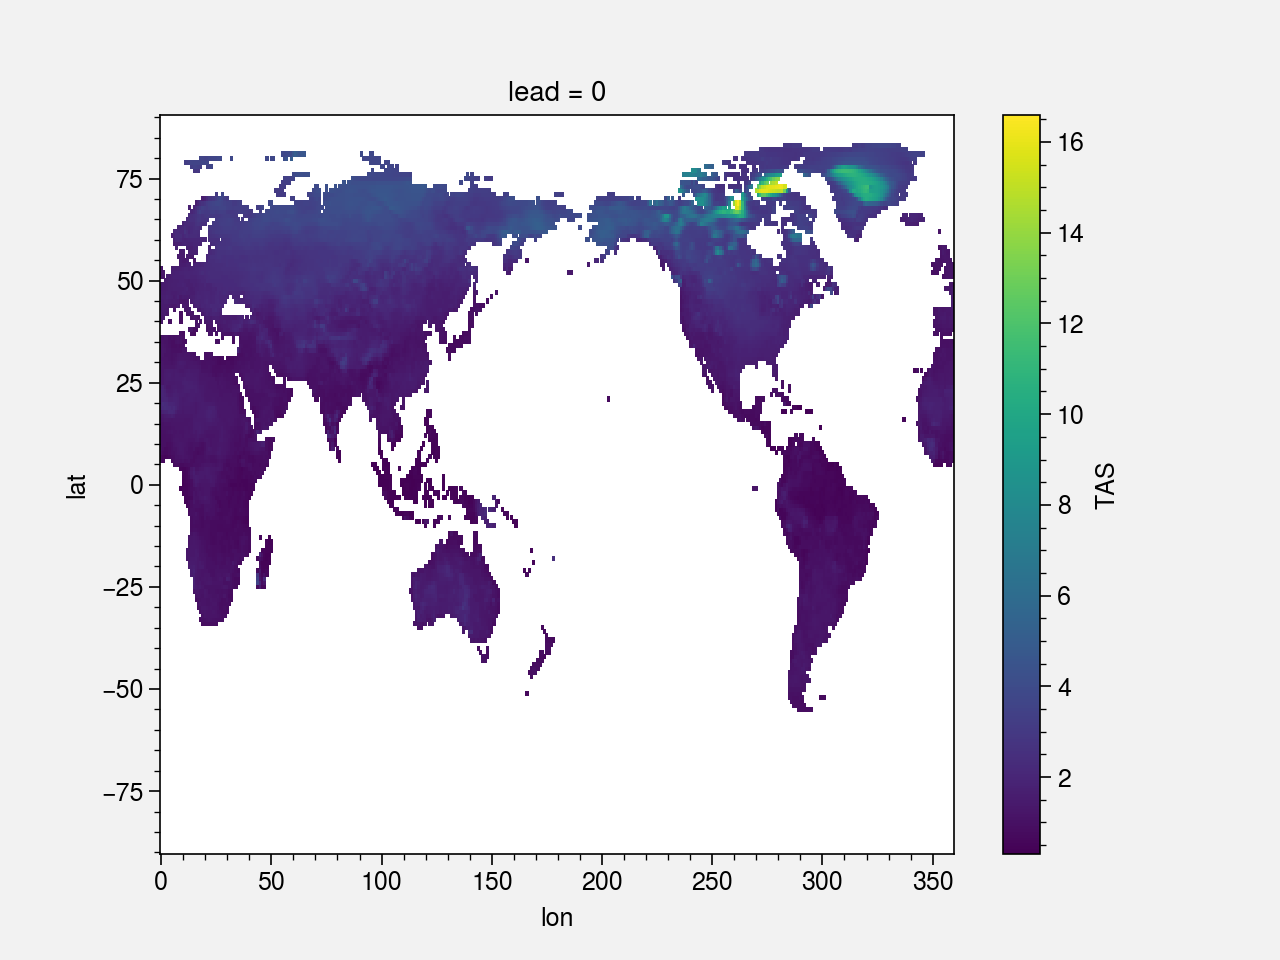

In [20]:
ds_metw_djf.sel(lead=0).plot()

Following two cells calculate the cosine area weight and then concatenates.

In [21]:
metw_djf_aw = []
met2_djf_aw = []
met2_5_djf_aw = []
met2_jja_aw = []
met2_5_jja_aw = []
met1_djf_aw = []
met1_5_djf_aw = []
met1_jja_aw = []
met1_5_jja_aw = []

for i in range(3):
    da = area_weight(ds_metw_djf.sel(lead=i),ds_metw_djf.lat)
    metw_djf_aw.append(da)
    
    da = area_weight(ds_met2_djf.sel(lead=i),ds_met2_djf.lat)
    met2_djf_aw.append(da)
    
    da = area_weight(ds_met2_5_djf.sel(lead=i),ds_met2_5_djf.lat)
    met2_5_djf_aw.append(da)
    
    da = area_weight(ds_met1_djf.sel(lead=i),ds_met1_djf.lat)
    met1_djf_aw.append(da)
    
    da = area_weight(ds_met1_5_djf.sel(lead=i),ds_met1_5_djf.lat)
    met1_5_djf_aw.append(da)
    
    da = area_weight(ds_met2_jja.sel(lead=i),ds_met2_jja.lat)
    met2_jja_aw.append(da)
    
    da = area_weight(ds_met2_5_jja.sel(lead=i),ds_met2_5_jja.lat)
    met2_5_jja_aw.append(da)
    
    da = area_weight(ds_met1_jja.sel(lead=i),ds_met1_jja.lat)
    met1_jja_aw.append(da)
    
    da = area_weight(ds_met1_5_jja.sel(lead=i),ds_met1_5_jja.lat)
    met1_5_jja_aw.append(da)

In [22]:
ds_metw_djf_aw = xr.concat(metw_djf_aw,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_met2_djf_aw = xr.concat(met2_djf_aw,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_met2_5_djf_aw = xr.concat(met2_5_djf_aw,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_met1_djf_aw = xr.concat(met1_djf_aw,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_met1_5_djf_aw = xr.concat(met1_5_djf_aw,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_met2_jja_aw = xr.concat(met2_jja_aw,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_met2_5_jja_aw = xr.concat(met2_5_jja_aw,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_met1_jja_aw = xr.concat(met1_jja_aw,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_met1_5_jja_aw = xr.concat(met1_5_jja_aw,dim="lead",coords="minimal",compat="override",combine_attrs="override",)

If you care about ensemble spread run the following two cells

In [23]:
#calculate ensemble spread and area weight
sprw_djf_aw = []
spr2_djf_aw = []
spr2_5_djf_aw = []
spr2_jja_aw = []
spr2_5_jja_aw = []
spr1_djf_aw = []
spr1_5_djf_aw = []
spr1_jja_aw = []
spr1_5_jja_aw = []

for i in range(3):
    spr = hindaw_djf.sel(lead=i).TAS.std("member").mean("init")
    ds = area_weight(spr,hindaw_djf.lat)
    sprw_djf_aw.append(ds)

    spr = hinda2_djf.sel(lead=i).TAS.std("member").mean("init")
    ds = area_weight(spr,hinda2_djf.lat)
    spr2_djf_aw.append(ds)
    
    spr = hinda2_5_djf.sel(lead=i).TAS.std("member").mean("init")
    ds = area_weight(spr,hinda2_5_djf.lat)
    spr2_5_djf_aw.append(ds)
    
    spr = hinda1_djf.sel(lead=i).TAS.std("member").mean("init")
    ds = area_weight(spr,hinda1_djf.lat)
    spr1_djf_aw.append(ds)
    
    spr = hinda1_5_djf.sel(lead=i).TAS.std("member").mean("init")
    ds = area_weight(spr,hinda1_5_djf.lat)
    spr1_5_djf_aw.append(ds)
    
    spr = hinda2_jja.sel(lead=i).TAS.std("member").mean("init")
    ds = area_weight(spr,hinda2_jja.lat)
    spr2_jja_aw.append(ds)
    
    spr = hinda2_5_jja.sel(lead=i).TAS.std("member").mean("init")
    ds = area_weight(spr,hinda2_5_jja.lat)
    spr2_5_jja_aw.append(ds)
    
    spr = hinda1_jja.sel(lead=i).TAS.std("member").mean("init")
    ds = area_weight(spr,hinda1_jja.lat)
    spr1_jja_aw.append(ds)
    
    spr = hinda1_5_jja.sel(lead=i).TAS.std("member").mean("init")
    ds = area_weight(spr,hinda1_5_jja.lat)
    spr1_5_jja_aw.append(ds)

In [24]:
ds_sprw_djf_aw = xr.concat(sprw_djf_aw,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_spr2_djf_aw = xr.concat(spr2_djf_aw,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_spr2_5_djf_aw = xr.concat(spr2_5_djf_aw,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_spr1_djf_aw = xr.concat(spr1_djf_aw,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_spr1_5_djf_aw = xr.concat(spr1_5_djf_aw,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_spr2_jja_aw = xr.concat(spr2_jja_aw,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_spr2_5_jja_aw = xr.concat(spr2_5_jja_aw,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_spr1_jja_aw = xr.concat(spr1_jja_aw,dim="lead",coords="minimal",compat="override",combine_attrs="override",)
ds_spr1_5_jja_aw = xr.concat(spr1_5_jja_aw,dim="lead",coords="minimal",compat="override",combine_attrs="override",)

Making bars to plot a bar chart then plotting on the next cell. First for DJF, then JJA.

In [25]:
barWidth = 0.15
barsw = [ds_metw_djf_aw.sel(lead=0),
         ds_metw_djf_aw.sel(lead=1),
         ds_metw_djf_aw.sel(lead=2)]
rw = np.arange(len(barsw))
bars2_5 = [ds_met2_5_djf_aw.sel(lead=0),
           ds_met2_5_djf_aw.sel(lead=1),
           ds_met2_5_djf_aw.sel(lead=2)]
r2_5 = [x + barWidth + 0.025 for x in rw]
bars2 = [ds_met2_djf_aw.sel(lead=0),
         ds_met2_djf_aw.sel(lead=1),
         ds_met2_djf_aw.sel(lead=2)]
r2 = [x + barWidth + 0.025 for x in r2_5]
bars1_5 = [ds_met1_5_djf_aw.sel(lead=0),
           ds_met1_5_djf_aw.sel(lead=1),
           ds_met1_5_djf_aw.sel(lead=2)]
r1_5 = [x + barWidth + 0.025 for x in r2]
bars1 = [ds_met1_djf_aw.sel(lead=0),
         ds_met1_djf_aw.sel(lead=1),
         ds_met1_djf_aw.sel(lead=2)]
r1 = [x + barWidth + 0.025 for x in r1_5]

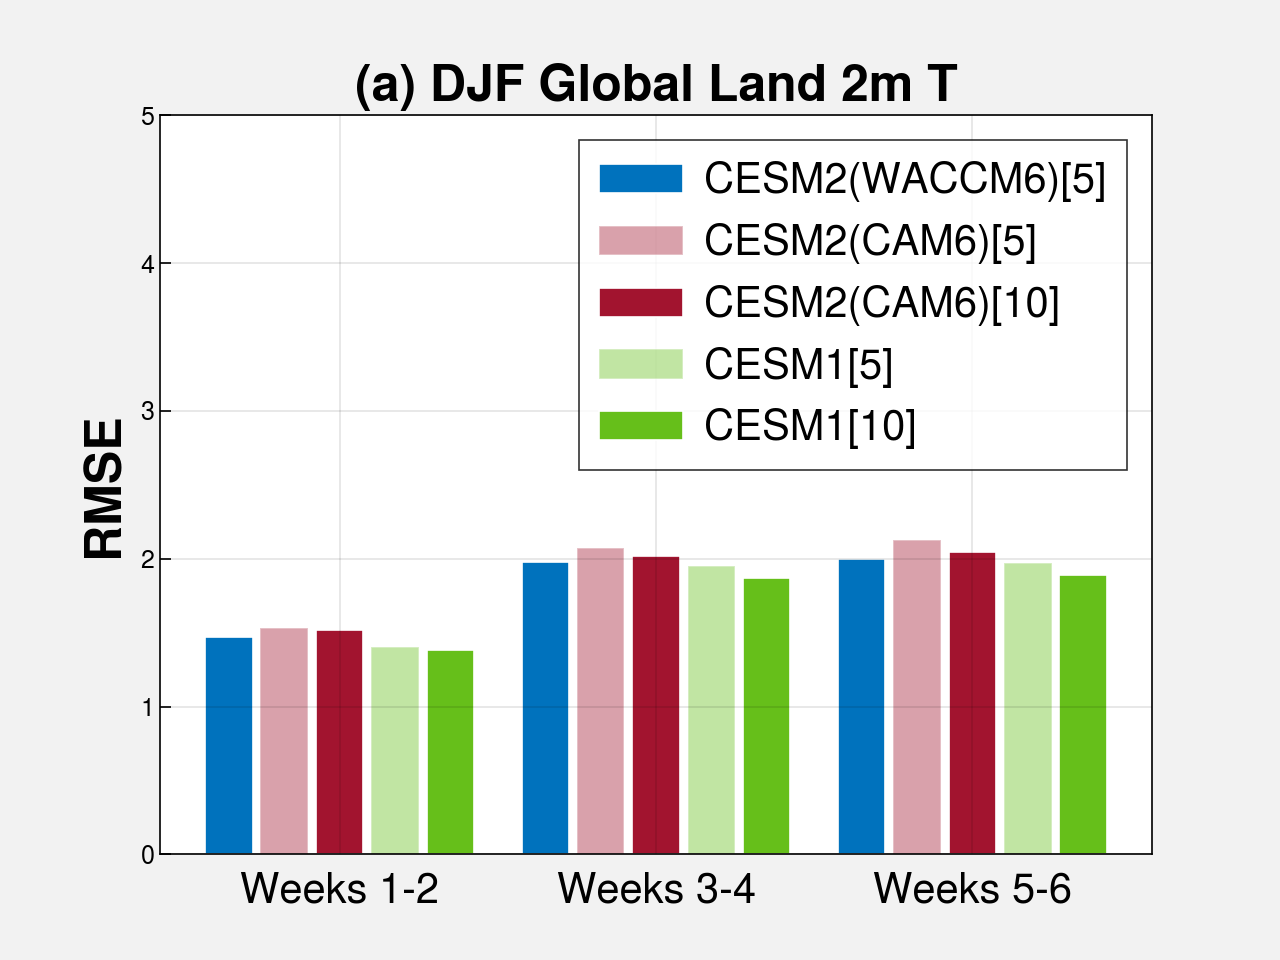

In [26]:
plt.bar(rw, barsw, width = barWidth, color = (0, 0.4470, 0.7410), edgecolor="white", label="CESM2(WACCM6)[5]")
plt.bar(r2_5, bars2_5, width = barWidth, color = (0.6350, 0.0780, 0.1840), alpha=0.4, edgecolor="white", label="CESM2(CAM6)[5]")
plt.bar(r2, bars2, width = barWidth, color = (0.6350, 0.0780, 0.1840), edgecolor="white", label="CESM2(CAM6)[10]")
plt.bar(r1_5, bars1_5, width = barWidth, color = (0.4, .75, 0.1), alpha=0.4, edgecolor="white", label="CESM1[5]")
plt.bar(r1, bars1, width = barWidth, color = (0.4, .75, 0.1), edgecolor="white", label="CESM1[10]")
plt.xticks([r + barWidth + 0.2 for r in range(len(bars1))], ["Weeks 1-2", "Weeks 3-4", "Weeks 5-6"],fontsize=15)
plt.tick_params(axis = "y", direction = "in", which = "both")
plt.tick_params(axis = "y", which = "minor", left = False)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
if metric=="acc" or metric=="rps":
    y_locator = FixedLocator([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]) #for rps and acc
    plt.gca().yaxis.set_major_locator(y_locator) #for rps and acc
    plt.ylim(0,1.0) #for rps and acc
#elif metric=="rps":
#    plt.ylim(0,1.5)
elif metric=="crpss" or metric=="rpss":
    plt.ylim(-0.5,0.1) #for crpss
elif metric=="crps":
    plt.ylim(0,6.0) #for crps
elif metric=="rmse":
    plt.ylim(0,5.0) #for rmse
plt.ylabel(metric.upper(),fontsize=18,fontweight="bold")
#plt.xlabel("Week",fontsize=18,fontweight="bold")
plt.rc('ytick',labelsize=15)
#plt.title("2m Temperature "+metric.upper()+" for "+domain+" land (DJF)")
#plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 14})
if domain == "North America":
    #plt.text(-0.15,0.93,"(b)",size=15,fontweight="bold")
    #plt.text(-0.15,5.6,"(b)",size=15,fontweight="bold")
    plt.title("(b) DJF North America Land 2m T",fontsize=18,fontweight="bold")
    #plt.savefig(metric+"_NAland_DJF_"+verifdata+".jpg",dpi=300,bbox_inches="tight")
elif domain == "global":
    #plt.text(-0.15,0.93,"(a)",size=15,fontweight="bold")
    #plt.text(-0.15,5.6,"(a)",size=15,fontweight="bold")
    plt.title("(a) DJF Global Land 2m T",fontsize=18,fontweight='bold')
    plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 15})
    #plt.savefig(metric+"_globalland_DJF_"+verifdata+".jpg",dpi=300,bbox_inches="tight")

In [27]:
barWidth = 0.175
bars2_5 = [ds_met2_5_jja_aw.sel(lead=0),
           ds_met2_5_jja_aw.sel(lead=1),
           ds_met2_5_jja_aw.sel(lead=2)]
r2_5 = np.arange(len(bars2_5))
bars2 = [ds_met2_jja_aw.sel(lead=0),
         ds_met2_jja_aw.sel(lead=1),
         ds_met2_jja_aw.sel(lead=2)]
r2 = [x + barWidth + 0.025 for x in r2_5]
bars1_5 = [ds_met1_5_jja_aw.sel(lead=0),
           ds_met1_5_jja_aw.sel(lead=1),
           ds_met1_5_jja_aw.sel(lead=2)]
r1_5 = [x + barWidth + 0.025 for x in r2]
bars1 = [ds_met1_jja_aw.sel(lead=0),
         ds_met1_jja_aw.sel(lead=1),
         ds_met1_jja_aw.sel(lead=2)]
r1 = [x + barWidth + 0.025 for x in r1_5]

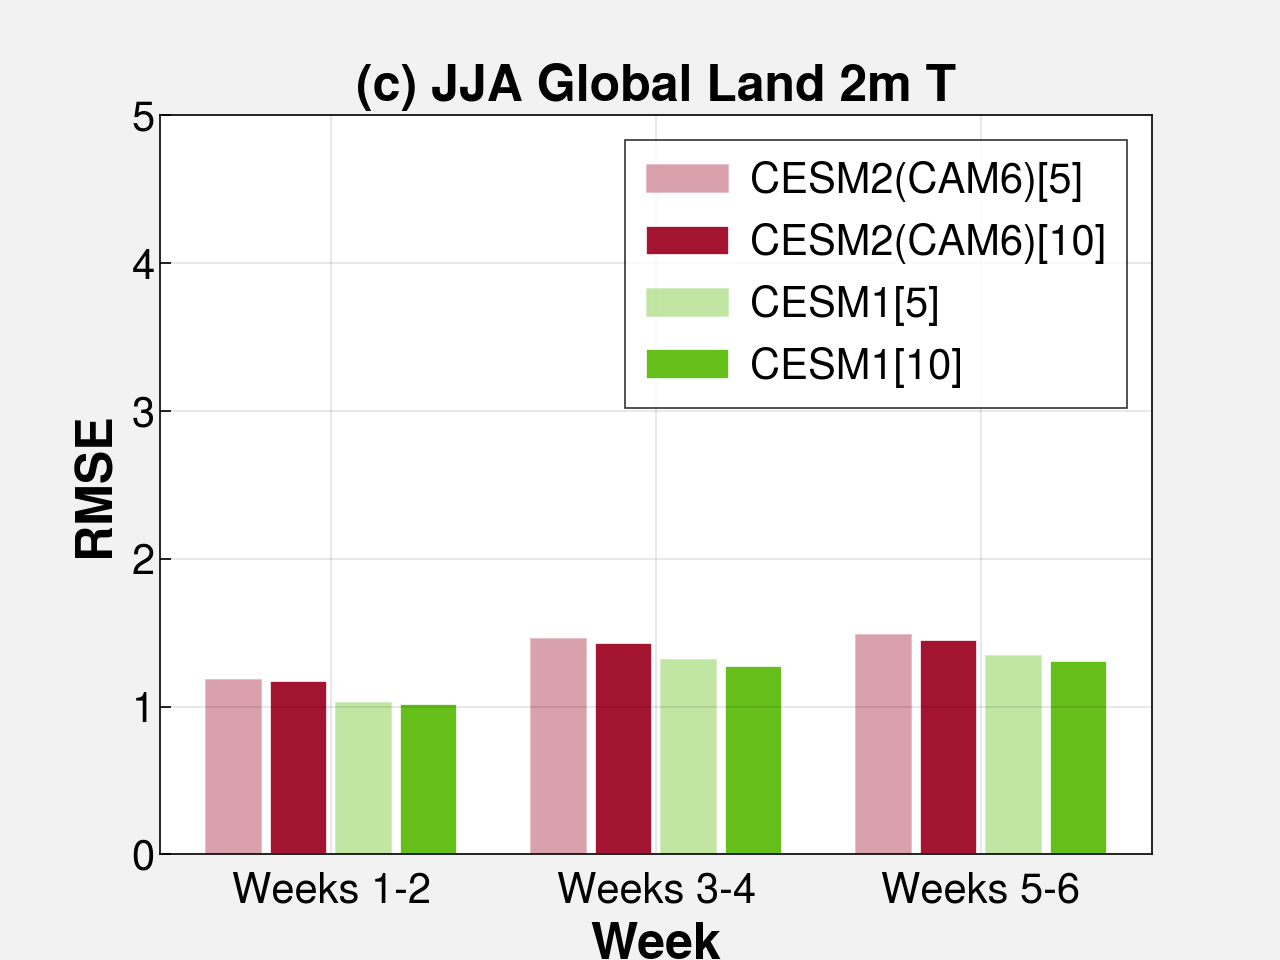

In [28]:
plt.bar(r2_5, bars2_5, width = barWidth, color = (0.6350, 0.0780, 0.1840), alpha=0.4, edgecolor="white", label="CESM2(CAM6)[5]")
plt.bar(r2, bars2, width = barWidth, color = (0.6350, 0.0780, 0.1840), edgecolor="white", label="CESM2(CAM6)[10]")
plt.bar(r1_5, bars1_5, width = barWidth, color = (0.4, .75, 0.1), alpha=0.4, edgecolor="white", label="CESM1[5]")
plt.bar(r1, bars1, width = barWidth, color = (0.4, .75, 0.1), edgecolor="white", label="CESM1[10]")
plt.xticks([r + barWidth + 0.125 for r in range(len(bars1))], ["Weeks 1-2", "Weeks 3-4", "Weeks 5-6"],fontsize=15)
plt.tick_params(axis = "y", direction = "in", which = "both")
plt.tick_params(axis = "y", which = "minor", left = False)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
if metric=="acc" or metric=="rps":
    y_locator = FixedLocator([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]) #for rps and acc
    plt.gca().yaxis.set_major_locator(y_locator) #for rps and acc
    plt.ylim(0,1.0) #for rps and acc
#elif metric=="rps":
#    plt.ylim(0,1.5)
elif metric=="crpss" or metric=="rpss":
    plt.ylim(-0.5,0.1) #for crpss
elif metric=="crps":
    plt.ylim(0,6.0) #for crps
elif metric=="rmse":
    plt.ylim(0,5.0) #for rmse
plt.ylabel(metric.upper(),fontsize=18,fontweight="bold")
plt.xlabel("Week",fontsize=18,fontweight="bold")
plt.rc('ytick',labelsize=15)
#plt.title("2m Temperature "+metric.upper()+" for "+domain+" land (JJA)")
#plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 14})
if domain == "North America":
    #plt.text(-0.15,0.93,"(b)",size=15,fontweight="bold")
    #plt.text(-0.15,5.6,"(b)",size=15,fontweight="bold")
    plt.title("(d) JJA North America Land 2m T",fontsize=18,fontweight="bold")
#    plt.savefig(metric+"_NAland_JJA_"+verifdata+".jpg",dpi=300,bbox_inches="tight")
elif domain == "global":
    #plt.text(-0.15,0.93,"(a)",size=15,fontweight="bold")
    #plt.text(-0.15,5.6,"(a)",size=15,fontweight="bold")
    plt.title("(c) JJA Global Land 2m T",fontsize=18,fontweight='bold')
    plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 15})
#    plt.savefig(metric+"_globalland_JJA_"+verifdata+".jpg",dpi=300,bbox_inches="tight")

**Run these cells if you want to plot both RMSE and ensemble spread!

In [29]:
barWidth = 0.067
barsw = [ds_metw_djf_aw.sel(lead=0),
         ds_metw_djf_aw.sel(lead=1),
         ds_metw_djf_aw.sel(lead=2)]
rw = np.arange(len(barsw))
barsw_s = [ds_sprw_djf_aw.sel(lead=0),
           ds_sprw_djf_aw.sel(lead=1),
           ds_sprw_djf_aw.sel(lead=2)]
rw_s = [x + barWidth + 0.025 for x in rw]
bars2_5 = [ds_met2_5_djf_aw.sel(lead=0),
           ds_met2_5_djf_aw.sel(lead=1),
           ds_met2_5_djf_aw.sel(lead=2)]
r2_5 = [x + barWidth + 0.025 for x in rw_s]
bars2_5_s = [ds_spr2_5_djf_aw.sel(lead=0),
             ds_spr2_5_djf_aw.sel(lead=1),
             ds_spr2_5_djf_aw.sel(lead=2)]
r2_5_s = [x + barWidth + 0.025 for x in r2_5]
bars2 = [ds_met2_djf_aw.sel(lead=0),
         ds_met2_djf_aw.sel(lead=1),
         ds_met2_djf_aw.sel(lead=2)]
r2 = [x + barWidth + 0.025 for x in r2_5_s]
bars2_s = [ds_spr2_djf_aw.sel(lead=0),
           ds_spr2_djf_aw.sel(lead=1),
           ds_spr2_djf_aw.sel(lead=2)]
r2_s = [x + barWidth + 0.025 for x in r2]
bars1_5 = [ds_met1_5_djf_aw.sel(lead=0),
           ds_met1_5_djf_aw.sel(lead=1),
           ds_met1_5_djf_aw.sel(lead=2)]
r1_5 = [x + barWidth + 0.025 for x in r2_s]
bars1_5_s = [ds_spr1_5_djf_aw.sel(lead=0),
             ds_spr1_5_djf_aw.sel(lead=1),
             ds_spr1_5_djf_aw.sel(lead=2)]
r1_5_s = [x + barWidth + 0.025 for x in r1_5]
bars1 = [ds_met1_djf_aw.sel(lead=0),
         ds_met1_djf_aw.sel(lead=1),
         ds_met1_djf_aw.sel(lead=2)]
r1 = [x + barWidth + 0.025 for x in r1_5_s]
bars1_s = [ds_spr1_djf_aw.sel(lead=0),
           ds_spr1_djf_aw.sel(lead=1),
           ds_spr1_djf_aw.sel(lead=2)]
r1_s = [x + barWidth + 0.025 for x in r1]

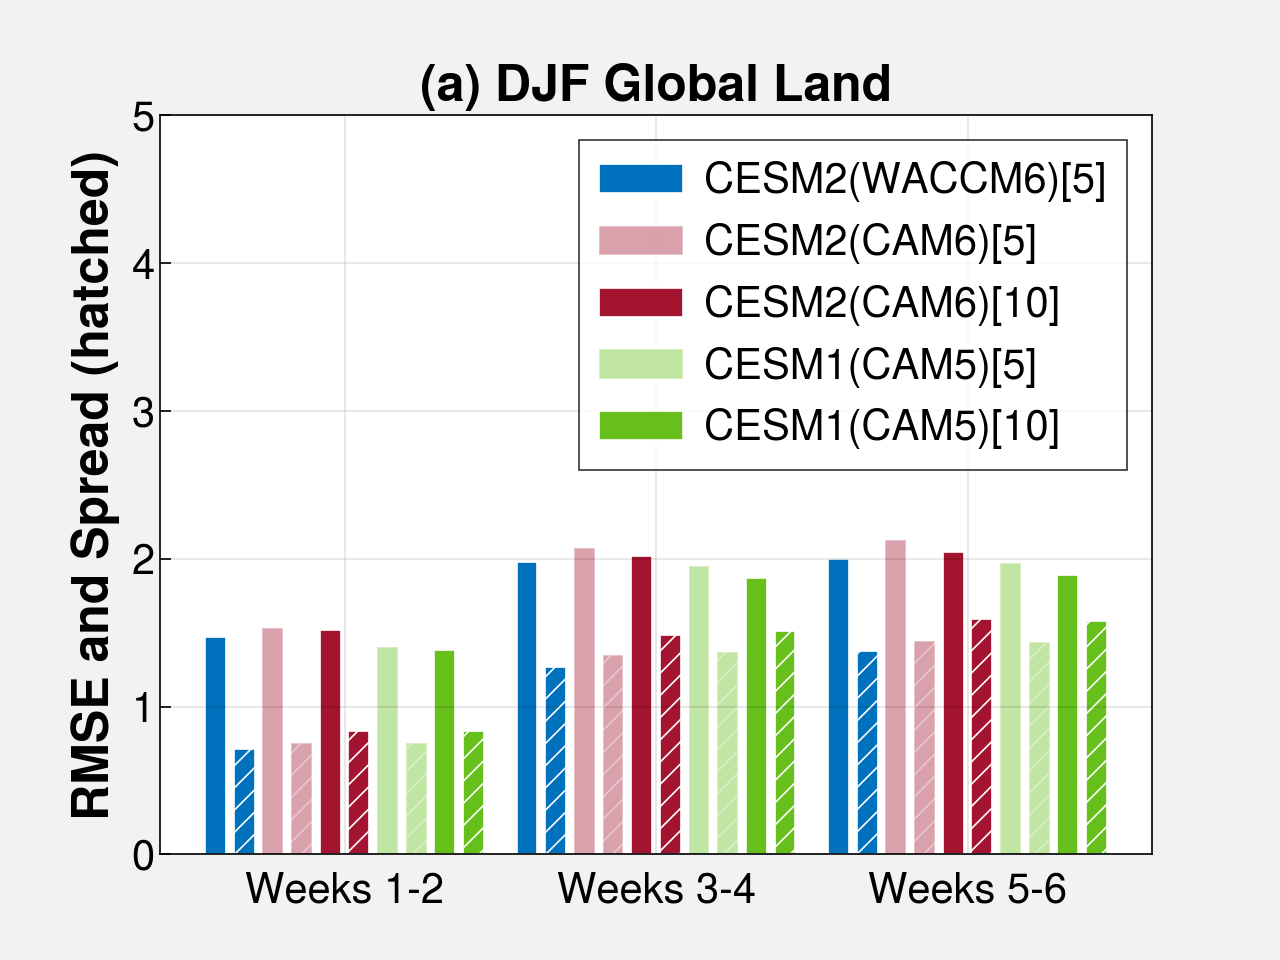

In [30]:
plt.bar(rw, barsw, width = barWidth, color = (0, 0.4470, 0.7410), edgecolor="white", label="CESM2(WACCM6)[5]")
plt.bar(rw_s, barsw_s, width = barWidth, color = (0, 0.4470, 0.7410), edgecolor="white", hatch="///")
plt.bar(r2_5, bars2_5, width = barWidth, color = (0.6350, 0.0780, 0.1840), alpha=0.4, edgecolor="white", label="CESM2(CAM6)[5]")
plt.bar(r2_5_s, bars2_5_s, width = barWidth, color = (0.6350, 0.0780, 0.1840), alpha=0.4, edgecolor="white", hatch="///")
plt.bar(r2, bars2, width = barWidth, color = (0.6350, 0.0780, 0.1840), edgecolor="white", label="CESM2(CAM6)[10]")
plt.bar(r2_s, bars2_s, width = barWidth, color = (0.6350, 0.0780, 0.1840), edgecolor="white", hatch="///")
plt.bar(r1_5, bars1_5, width = barWidth, color = (0.4, .75, 0.1), alpha=0.4, edgecolor="white", label="CESM1(CAM5)[5]")
plt.bar(r1_5_s, bars1_5_s, width = barWidth, color = (0.4, .75, 0.1), alpha=0.4, edgecolor="white", hatch="///")
plt.bar(r1, bars1, width = barWidth, color = (0.4, .75, 0.1), edgecolor="white", label="CESM1(CAM5)[10]")
plt.bar(r1_s, bars1_s, width = barWidth, color = (0.4, .75, 0.1), edgecolor="white", hatch="///")
plt.xticks([r + barWidth + 0.3475 for r in range(len(bars1))], ["Weeks 1-2", "Weeks 3-4", "Weeks 5-6"],fontsize=15)
plt.tick_params(axis = "y", direction = "in", which = "both")
plt.tick_params(axis = "y", which = "minor", left = False)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
if metric=="acc":
    y_locator = FixedLocator([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]) #for rps and acc
    plt.gca().yaxis.set_major_locator(y_locator) #for rps and acc
    plt.ylim(0,1.0) #for rps and acc
elif metric=="rps":
    plt.ylim(0,1.5)
elif metric=="crpss":
    plt.ylim(-0.3,0.1) #for crpss
elif metric=="crps":
    plt.ylim(0,6.0) #for crps
elif metric=="rmse":
    plt.ylim(0,5.0) #for rmse
plt.ylabel(metric.upper()+" and Spread (hatched)",fontsize=18,fontweight="bold")
#plt.xlabel("Week",fontsize=18,fontweight="bold")
plt.rc('ytick',labelsize=15)
#plt.title("2m Temperature "+metric.upper()+" and ensemble spread for "+domain+" land (DJF)")
#plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 14})
if domain == "North America":
    #plt.text(-0.1,5.6,"(b)",size=15,fontweight="bold")
    plt.title("(b) DJF North America Land",fontsize=18,fontweight="bold")
    #plt.savefig(metric+"_spread_NAland_DJF_"+verifdata+"_final.jpg",dpi=300,bbox_inches="tight")
elif domain == "global":
    #plt.text(-0.1,5.6,"(a)",size=15,fontweight="bold")
    plt.title("(a) DJF Global Land",fontsize=18,fontweight='bold')
    plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 15})
    #plt.savefig(metric+"_spread_globalland_DJF_"+verifdata+"_final.jpg",dpi=300,bbox_inches="tight")

In [31]:
barWidth = 0.085
bars2_5 = [ds_met2_5_jja_aw.sel(lead=0),
           ds_met2_5_jja_aw.sel(lead=1),
           ds_met2_5_jja_aw.sel(lead=2)]
r2_5 = np.arange(len(bars2_5))
bars2_5_s = [ds_spr2_5_jja_aw.sel(lead=0),
             ds_spr2_5_jja_aw.sel(lead=1),
             ds_spr2_5_jja_aw.sel(lead=2)]
r2_5_s = [x + barWidth + 0.025 for x in r2_5]
bars2 = [ds_met2_jja_aw.sel(lead=0),
         ds_met2_jja_aw.sel(lead=1),
         ds_met2_jja_aw.sel(lead=2)]
r2 = [x + barWidth + 0.025 for x in r2_5_s]
bars2_s = [ds_spr2_jja_aw.sel(lead=0),
           ds_spr2_jja_aw.sel(lead=1),
           ds_spr2_jja_aw.sel(lead=2)]
r2_s = [x + barWidth + 0.025 for x in r2]
bars1_5 = [ds_met1_5_jja_aw.sel(lead=0),
           ds_met1_5_jja_aw.sel(lead=1),
           ds_met1_5_jja_aw.sel(lead=2)]
r1_5 = [x + barWidth + 0.025 for x in r2_s]
bars1_5_s = [ds_spr1_5_jja_aw.sel(lead=0),
             ds_spr1_5_jja_aw.sel(lead=1),
             ds_spr1_5_jja_aw.sel(lead=2)]
r1_5_s = [x + barWidth + 0.025 for x in r1_5]
bars1 = [ds_met1_jja_aw.sel(lead=0),
         ds_met1_jja_aw.sel(lead=1),
         ds_met1_jja_aw.sel(lead=2)]
r1 = [x + barWidth + 0.025 for x in r1_5_s]
bars1_s = [ds_spr1_jja_aw.sel(lead=0),
           ds_spr1_jja_aw.sel(lead=1),
           ds_spr1_jja_aw.sel(lead=2)]
r1_s = [x + barWidth + 0.025 for x in r1]

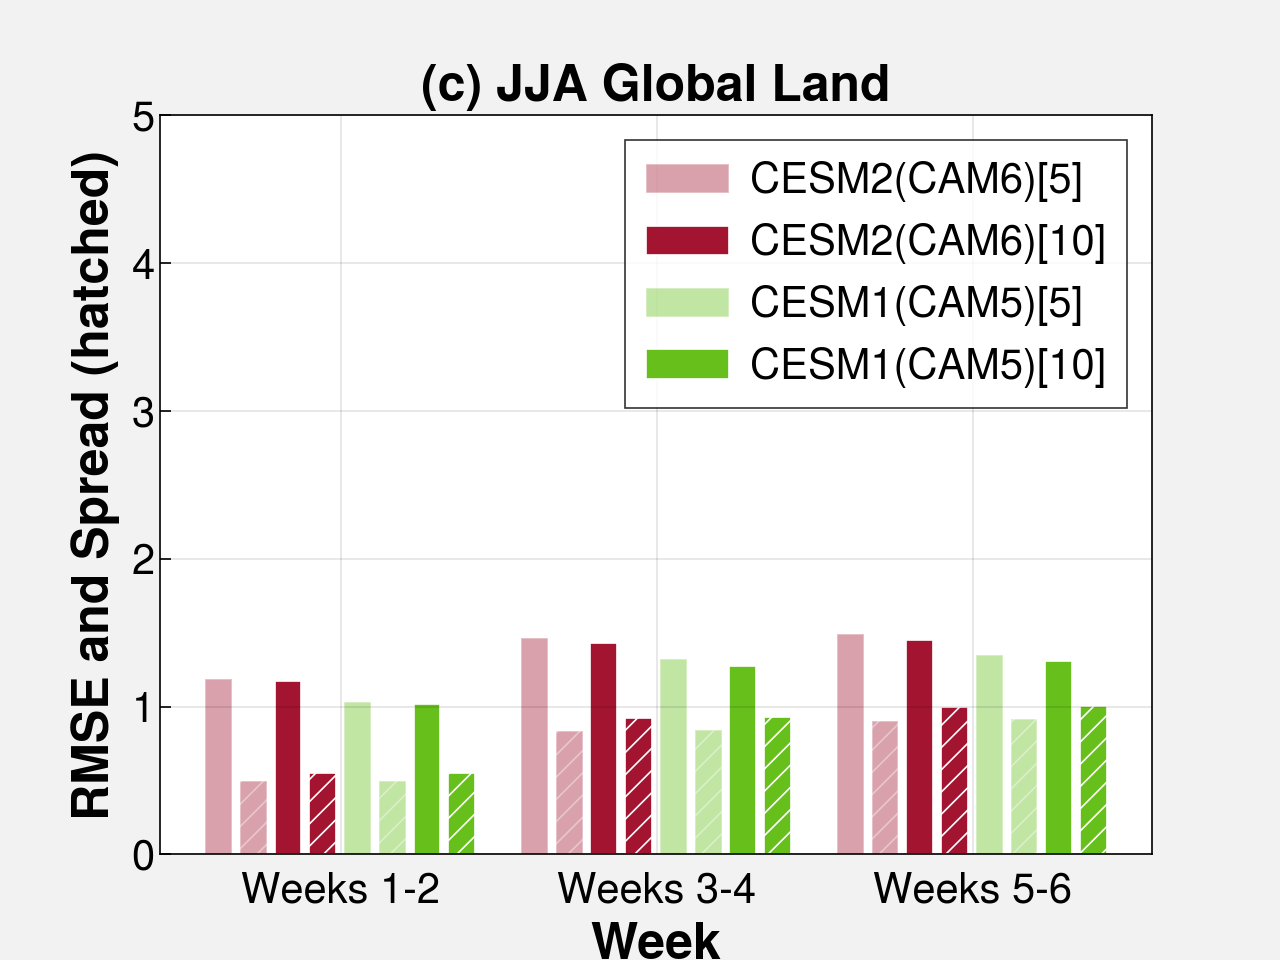

In [32]:
plt.bar(r2_5, bars2_5, width = barWidth, color = (0.6350, 0.0780, 0.1840), alpha=0.4, edgecolor="white", label="CESM2(CAM6)[5]")
plt.bar(r2_5_s, bars2_5_s, width = barWidth, color = (0.6350, 0.0780, 0.1840), alpha=0.4, edgecolor="white", hatch="///")
plt.bar(r2, bars2, width = barWidth, color = (0.6350, 0.0780, 0.1840), edgecolor="white", label="CESM2(CAM6)[10]")
plt.bar(r2_s, bars2_s, width = barWidth, color = (0.6350, 0.0780, 0.1840), edgecolor="white", hatch="///")
plt.bar(r1_5, bars1_5, width = barWidth, color = (0.4, .75, 0.1), alpha=0.4, edgecolor="white", label="CESM1(CAM5)[5]")
plt.bar(r1_5_s, bars1_5_s, width = barWidth, color = (0.4, .75, 0.1), alpha=0.4, edgecolor="white", hatch="///")
plt.bar(r1, bars1, width = barWidth, color = (0.4, .75, 0.1), edgecolor="white", label="CESM1(CAM5)[10]")
plt.bar(r1_s, bars1_s, width = barWidth, color = (0.4, .75, 0.1), edgecolor="white", hatch="///")
plt.xticks([r + barWidth + 0.3025 for r in range(len(bars1))], ["Weeks 1-2", "Weeks 3-4", "Weeks 5-6"],fontsize=15)
plt.tick_params(axis = "y", direction = "in", which = "both")
plt.tick_params(axis = "y", which = "minor", left = False)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
if metric=="acc":
    y_locator = FixedLocator([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]) #for rps and acc
    plt.gca().yaxis.set_major_locator(y_locator) #for rps and acc
    plt.ylim(0,1.0) #for rps and acc
elif metric=="rps":
    plt.ylim(0,1.5)
elif metric=="crpss":
    plt.ylim(-0.3,0.1) #for crpss
elif metric=="crps":
    plt.ylim(0,6.0) #for crps
elif metric=="rmse":
    plt.ylim(0,5.0) #for rmse
plt.ylabel(metric.upper()+" and Spread (hatched)",fontsize=18,fontweight="bold")
plt.xlabel("Week",fontsize=18,fontweight="bold")
plt.rc('ytick',labelsize=15)
#plt.title("2m Temperature "+metric.upper()+" and ensemble spread for "+domain+" land (DJF)")
#plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 14})
if domain == "North America":
    #plt.text(-0.1,5.6,"(b)",size=15,fontweight="bold")
    plt.title("(d) JJA North America Land",fontsize=18,fontweight="bold")
    #plt.savefig(metric+"_spread_NAland_JJA_"+verifdata+"_final.jpg",dpi=300,bbox_inches="tight")
elif domain == "global":
    #plt.text(-0.1,5.6,"(a)",size=15,fontweight="bold")
    plt.title("(c) JJA Global Land",fontsize=18,fontweight='bold')
    plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 15})
    #plt.savefig(metric+"_spread_globalland_JJA_"+verifdata+"_final.jpg",dpi=300,bbox_inches="tight")